# readfish barcode aware figure 1

In [1]:
import time
import lzma
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from readpaf import parse_paf

In [2]:
plt.style.use('../figures.mplstyle')

### Read in "Truth" Paf file

In [4]:
truth_paf = "figure_1_a_paf_files/original_hac_multi_calls.paf.xz"
with lzma.open(truth_paf, "rt") as fh:
    try:
        truth_paf_df = parse_paf(fh, dataframe=True)
    except Exception as e:
        print (f"Error reading in paf file - {repr(e)}")

truth_paf_df.drop_duplicates(['query_name'],keep='first',inplace=True)

truth_paf_df["map_start"]= np.where(
    truth_paf_df['strand']=='+', 
    truth_paf_df['target_start'],
    truth_paf_df['target_end'],
)

### Loop through the truncated PAF files

#### Calculate precision, recall, F1 for mappings within 100 base of original

In [5]:
result_dict = {}
path_to_paf_files = Path("figure_1_a_paf_files/")
prog = tqdm(list(path_to_paf_files.rglob("*.paf.xz")), dynamic_ncols=True)
# this line should ensure a perfect match between calls
for comp_path in prog:
    prog.set_description(f"Processing {comp_path}")
    with lzma.open(comp_path, "rt") as handle:
        try:
            comp_df = parse_paf(handle, dataframe=True)
        except FileNotFoundError as e:
            print(f"Error loading file {file} -> {repr(e)}")
            break
    comp_path = comp_path.name
    # lose multi mappings
    comp_df.drop_duplicates(["query_name"], keep="first", inplace=True)
    comp_df["map_start"] = pd.to_numeric(
        np.where(
            comp_df["strand"] == "+", comp_df["target_start"], comp_df["target_end"]
        )
    )

    result_all = truth_paf_df.merge(comp_df, on="query_name")
    result_all["same_strand"] = result_all["strand_x"] == result_all["strand_y"]
    result_all["ref_mapped"] = result_all.target_name_x != "*"
    result_all["query_mapped"] = result_all.target_name_y != "*"
    result_all["same_mapped"] = result_all.target_name_x == result_all.target_name_y
    for window in [50,100,1000]:
        result_all["within_window"] = (
            abs(result_all.map_start_x.values - result_all.map_start_y.values) <= window
        )

        # True negatives will be:
        result_all["true_negative"] = result_all["target_name_x"].eq("*") & result_all[
            "target_name_y"
        ].eq("*")
        # False negatives will be:
        result_all["false_negative"] = result_all["target_name_x"].ne("*") & result_all[
            "target_name_y"
        ].eq("*")

        # True Positives
        result_all["true_positive"] = (
            result_all["same_mapped"]
            & result_all["target_name_x"].ne("*")
            & result_all["within_window"]
        )

        # False Positives
        result_all["false_positive"] = result_all["query_mapped"] & (
            (result_all.target_name_x != result_all.target_name_y)
            | (
                abs(result_all.map_start_x.values - result_all.map_start_y.values)
                > window
            )
        )

        comparison_dict = {}
        # loop through and get counts for each one to put into the dicitonary
        for result in [
            "true_positive",
            "false_positive",
            "true_negative",
            "false_negative",
        ]:
            comparison_dict[result] = result_all[result].value_counts().to_dict().get(True, 0)
        comparison_dict["total"] = result_all.shape[0]

        # time for some precision
        try:
             precision = comparison_dict["true_positive"] / (
                comparison_dict["true_positive"] + comparison_dict["false_positive"]
            )
        except ZeroDivisionError:
            precision = 0
        comparison_dict["precision"] = precision

        # time for some recall
        
        comparison_dict["recall"] = comparison_dict["true_positive"] / (
            comparison_dict["true_positive"] + comparison_dict["false_negative"]
        )
        
        try:
            F1 = (
                2
                * (comparison_dict["precision"] * comparison_dict["recall"])
                / (comparison_dict["precision"] + comparison_dict["recall"])
            )
        except ZeroDivisionError:
            F1 = 0
        # time for some F1
        comparison_dict["F1"] = F1

        result_dict[(comp_path, window)] = comparison_dict


  0%|                                                                                                         …

In [6]:
f1_plot_df = (
    pd.DataFrame(result_dict)
    .T.reset_index()
    .rename(columns={"level_0": "filename", "level_1": "window_width"})
)
f1_plot_df[[ "read_length","caller"]] = (
    f1_plot_df["filename"].str.split(pat="_", expand=True).loc[:, 0:1]
)
f1_plot_df["read_length"] = f1_plot_df["read_length"].str.replace(
    ".paf", "", regex=False
)

In [7]:
file="figure_1_b_files/original_hac_seq_sum.txt.xz"

fields=['read_id','barcode_arrangement','barcode_front_id','barcode_rear_id','barcode_front_foundseq','barcode_rear_foundseq']

truth_seq_sum_df = pd.read_csv(file, usecols = fields, sep="\t")

In [8]:
barc_results = dict()
pbar1 = tqdm(['sup','hac','fast','sketch'], dynamic_ncols=True)
for model in pbar1:
    pbar1.set_description(f"{model=}")
    barc_results[model]=dict()
    for length in ["original", "800", "1200", "1600", "2000", "2400", "2800", "3200", "3600", "4000", "5000", "6000", "7000", "8000", "9000", "10000"]:
        file="figure_1_b_files/{}_{}_seq_sum.txt.xz".format(length, model)
        fields=['read_id','barcode_arrangement','barcode_front_id','barcode_rear_id','barcode_front_foundseq','barcode_rear_foundseq']
        sup_seq_sum_df = pd.read_csv(file, usecols = fields, sep="\t")
        barc_all = truth_seq_sum_df.merge(sup_seq_sum_df,on="read_id", how='left')
        barc_all["same"]=np.where(barc_all['barcode_arrangement_x']==barc_all['barcode_arrangement_y'], 1,0)
        tn = len(barc_all[barc_all['same'].eq(1) & barc_all['barcode_arrangement_x'].eq('unclassified')])
        tp = len(barc_all[barc_all['same'].eq(1) & ~barc_all['barcode_arrangement_x'].eq('unclassified')])
        fn = len(barc_all[~barc_all['barcode_arrangement_x'].eq('unclassified') & barc_all['barcode_arrangement_y'].eq('unclassified')])
        fp = len(barc_all[barc_all['barcode_arrangement_x'].eq('unclassified') & ~barc_all['barcode_arrangement_y'].eq('unclassified')])
        # print (tn,tp,fn,fp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2 * (precision * recall)/(precision + recall)
        # print (precision, recall, f1)
        barc_results[model][length]=dict()
        barc_results[model][length]['precision']=precision
        barc_results[model][length]['recall']=recall
        barc_results[model][length]['f1']=f1

  0%|                                                                                                         …

In [9]:
barcs = pd.concat({k: pd.DataFrame(v).T for k, v in barc_results.items()}, axis=0)
barcs.reset_index(inplace=True)
barcs = barcs.rename(columns={"level_0": "caller", "level_1": "length"})

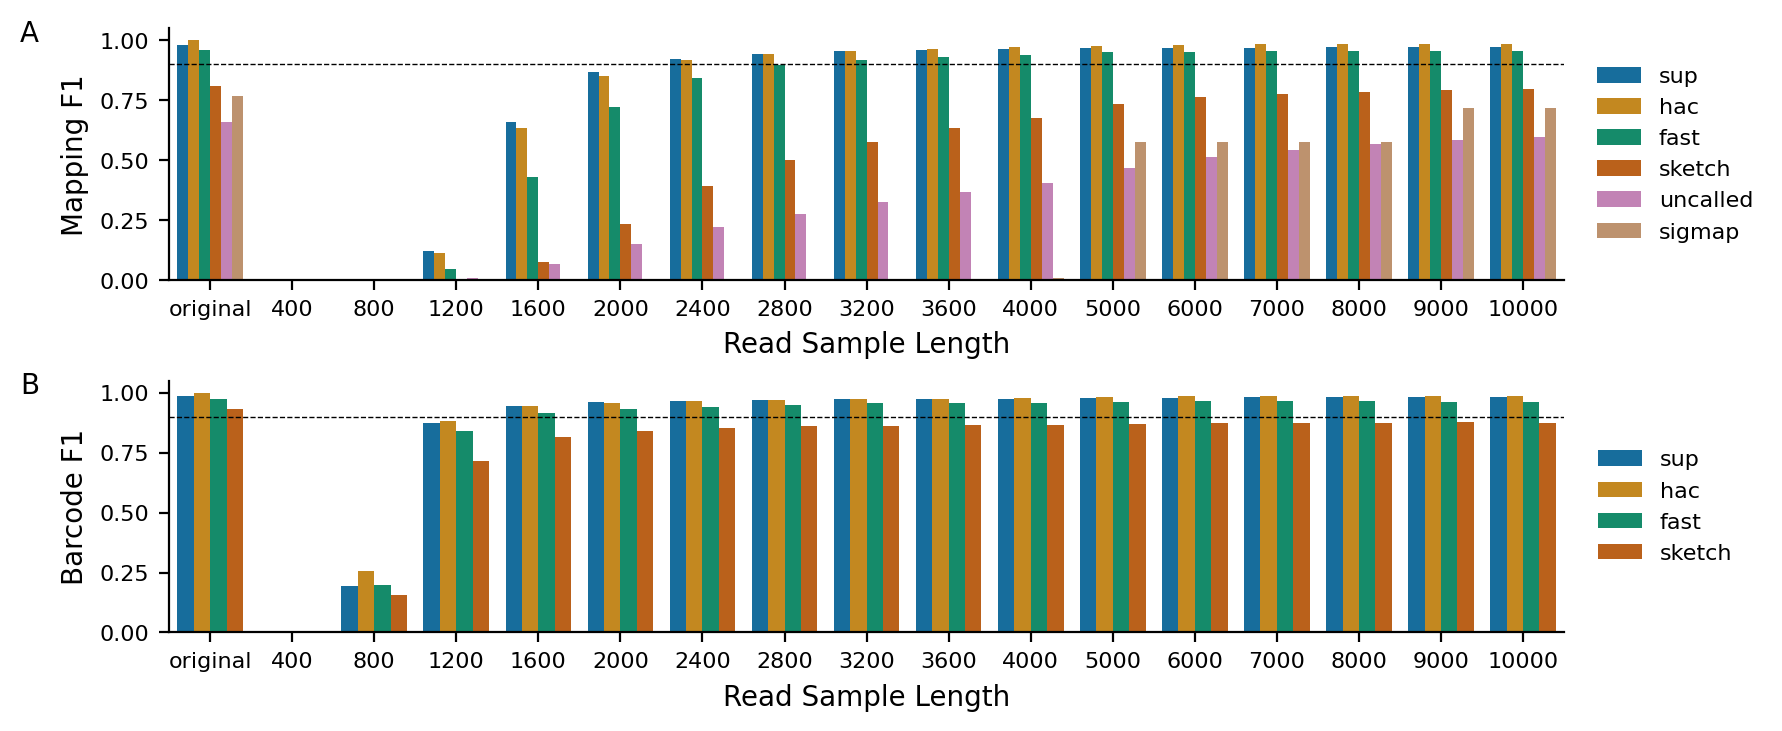

In [10]:
shared_kws = {
    "order": ["original"]
    + list(map(str, range(400, 4000, 400)))
    + list(map(str, range(4000, 10001, 1000))),
    "palette": "colorblind",
}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 4), gridspec_kw={"hspace": 0.4})
sns.barplot(
    ax=ax1,
    x="read_length",
    y="F1",
    hue="caller",
    data=f1_plot_df,
    ci=None,
    hue_order=["sup", "hac", "fast", "sketch", "uncalled", "sigmap"],
    **shared_kws,
)

ax1.set(ylabel="Mapping F1")
ax1.set(xlabel="Read Sample Length")
ax1.axhline(0.9, lw=0.5, ls="--", c="k")

sns.move_legend(
    ax1,
    loc="center right",
    bbox_to_anchor=(1.15, 0.5),
    fontsize=8,
    frameon=False,
    title=None,
)

ax1.text(
    -0.1,
    0.98,
    "A",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax1.transAxes,
)

# Plot B
sns.barplot(
    ax=ax2,
    x="length",
    y="f1",
    hue="caller",
    data=barcs,
    hue_order=["sup", "hac", "fast", "sketch"],
    **shared_kws,
)
ax2.axhline(0.9, lw=0.5, ls="--", c="k")
ax2.set(ylabel="Barcode F1")
ax2.set(xlabel="Read Sample Length")

sns.move_legend(
    ax2,
    loc="center right",
    bbox_to_anchor=(1.135, 0.5),
    fontsize=8,
    frameon=False,
    title=None,
)

ax2.text(
    -0.1,
    0.98,
    "B",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax2.transAxes,
)

fig.savefig("figure_1.pdf", bbox_inches="tight")